In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

In [2]:
df_train = pd.read_parquet("results_EMR/results_train_raw")
df_test = pd.read_parquet("results_EMR/results_test_raw")

In [3]:
print(f"🔹 Nombre de classes dans le train : {df_train['label'].nunique()}")
print(f"🔸 Nombre de classes dans le test : {df_test['label'].nunique()}")


🔹 Nombre de classes dans le train : 201
🔸 Nombre de classes dans le test : 201


/tmp/ipykernel_133/3565199099.py:30: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


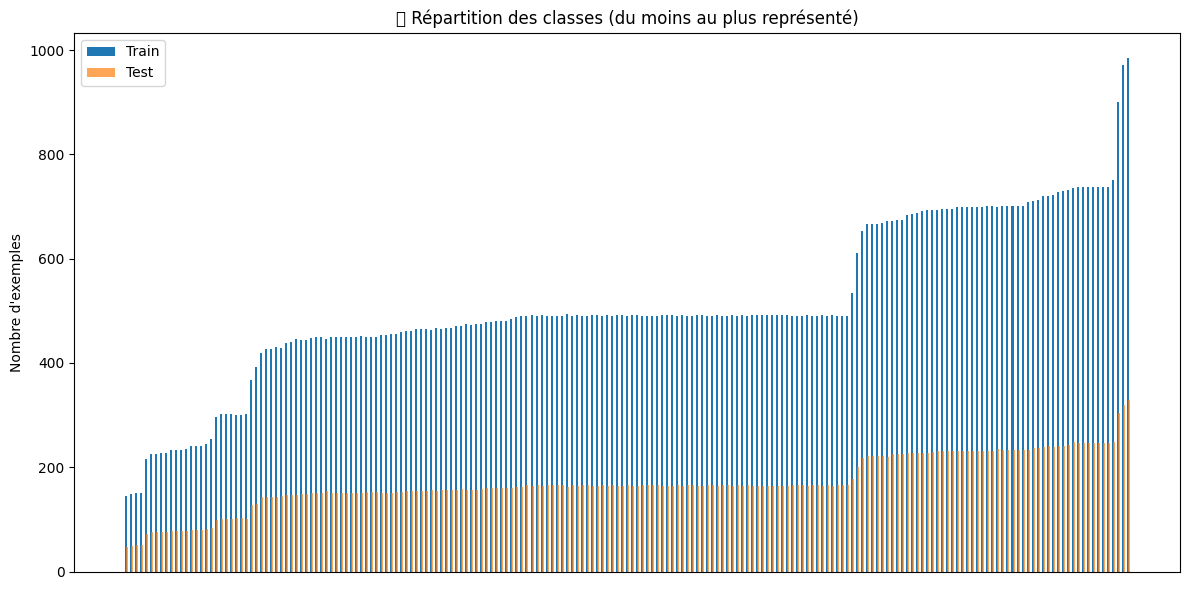

In [4]:
import matplotlib.pyplot as plt

# Comptage des classes
train_counts = df_train['label'].value_counts()
test_counts = df_test['label'].value_counts()

# Fusion des index pour avoir tous les labels
all_labels = sorted(set(train_counts.index).union(set(test_counts.index)))

# Construction d'un DataFrame combiné pour faciliter le tri
import pandas as pd

df_counts = pd.DataFrame({
    'label': all_labels,
    'train': [train_counts.get(label, 0) for label in all_labels],
    'test': [test_counts.get(label, 0) for label in all_labels],
})
df_counts['total'] = df_counts['train'] + df_counts['test']
df_counts = df_counts.sort_values(by='total')  # tri par effectif total croissant

# Affichage des barres
x = range(len(df_counts))
plt.figure(figsize=(12, 6))
plt.bar(x, df_counts['train'], width=0.4, label='Train', align='center')
plt.bar(x, df_counts['test'], width=0.4, label='Test', align='edge', alpha=0.7)
plt.xticks([])  # pas de labels sur l’axe x
plt.ylabel("Nombre d'exemples")
plt.title("📊 Répartition des classes (du moins au plus représenté)")
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# Extraction des classes les plus communes (depuis train)
top_labels = df_train['label'].value_counts().nlargest(50).index.tolist()
df_train = df_train[df_train['label'].isin(top_labels)].reset_index(drop=True)
df_test = df_test[df_test['label'].isin(top_labels)].reset_index(drop=True)

In [7]:
# Extraction des vecteurs PCA
X_train = np.stack(df_train['scaled_features'].apply(lambda d: d['values']))
X_test = np.stack(df_test['scaled_features'].apply(lambda d: d['values']))
y_train = df_train['label'].values
y_test = df_test['label'].values

In [8]:
# Encodage des labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [9]:
# Entraînement modèle 1: lr
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
model.fit(X_train, y_train_encoded)

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'multinomial'


In [10]:
# Entraînement modèle 2: randomforest
# from sklearn.ensemble import RandomForestClassifier

# model = RandomForestClassifier(
#     n_estimators=100,  # nombre d'arbres
#     max_depth=None,    # profondeur libre
#     random_state=42,
#     n_jobs=-1          # parallélisation
# )
# model.fit(X_train, y_train_encoded)

In [11]:
# Entrainement modèle 3 GradientBoosting
# from sklearn.ensemble import HistGradientBoostingClassifier

# Modèle avec quelques hyperparamètres ajustés
# model = HistGradientBoostingClassifier(
#     learning_rate=0.1,
#     max_iter=150,
#     max_leaf_nodes=64,
#     l2_regularization=1.0,
#     early_stopping=True,
#     random_state=42
# )

# start = time.time()
# model.fit(X_train, y_train_encoded)
# print(f"Temps d'entraînement : {time.time() - start:.2f} sec")

In [ ]:
# Entrainement modèle 4 XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import time

# Modèle XGBoost multiclass
model = XGBClassifier(
    objective='multi:softprob',
    num_class=201,
    learning_rate=0.1,
    n_estimators=150,
    max_depth=7,
    tree_method='hist',  # 'gpu_hist' si GPU dispo
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    verbosity=1
)

start = time.time()
model.fit(X_train, y_train_encoded)
print(f"Temps d'entraînement : {time.time() - start:.2f} sec")

In [12]:
# Prédictions
y_pred_encoded = model.predict(X_test)
y_pred = le.inverse_transform(y_pred_encoded)
y_test_labels = le.inverse_transform(y_test_encoded)

In [13]:
# ARI et Jensen-Shannon
ari = adjusted_rand_score(y_test_labels, y_pred)
print(f"Adjusted Rand Index (ARI) : {ari:.4f}")

real_dist = np.array([sum(y_test_labels == label) for label in top_labels])
pred_dist = np.array([sum(y_pred == label) for label in top_labels])
real_dist = real_dist / real_dist.sum()
pred_dist = pred_dist / pred_dist.sum()
js_distance = jensenshannon(real_dist, pred_dist)
print(f"Jensen-Shannon Distance : {js_distance:.4f}")

# Rapport
print(classification_report(y_test_labels, y_pred, zero_division=0))

Adjusted Rand Index (ARI) : 0.9751
Jensen-Shannon Distance : 0.0204
                          precision    recall  f1-score   support

                Apple 10       1.00      1.00      1.00       231
                Apple 13       0.94      1.00      0.97       235
                Apple 19       1.00      1.00      1.00       241
                 Apple 7       1.00      1.00      1.00       229
                 Apple 8       1.00      1.00      1.00       228
                 Apple 9       1.00      1.00      1.00       231
      Apple Red Yellow 2       1.00      1.00      1.00       219
             Apple hit 1       1.00      1.00      1.00       234
            Apple worm 1       1.00      1.00      1.00       231
         Avocado Black 1       0.99      1.00      1.00       231
         Avocado Green 1       1.00      1.00      1.00       231
Blackberrie not rippen 1       1.00      1.00      1.00       225
    Cactus fruit green 1       1.00      1.00      1.00       231
      C

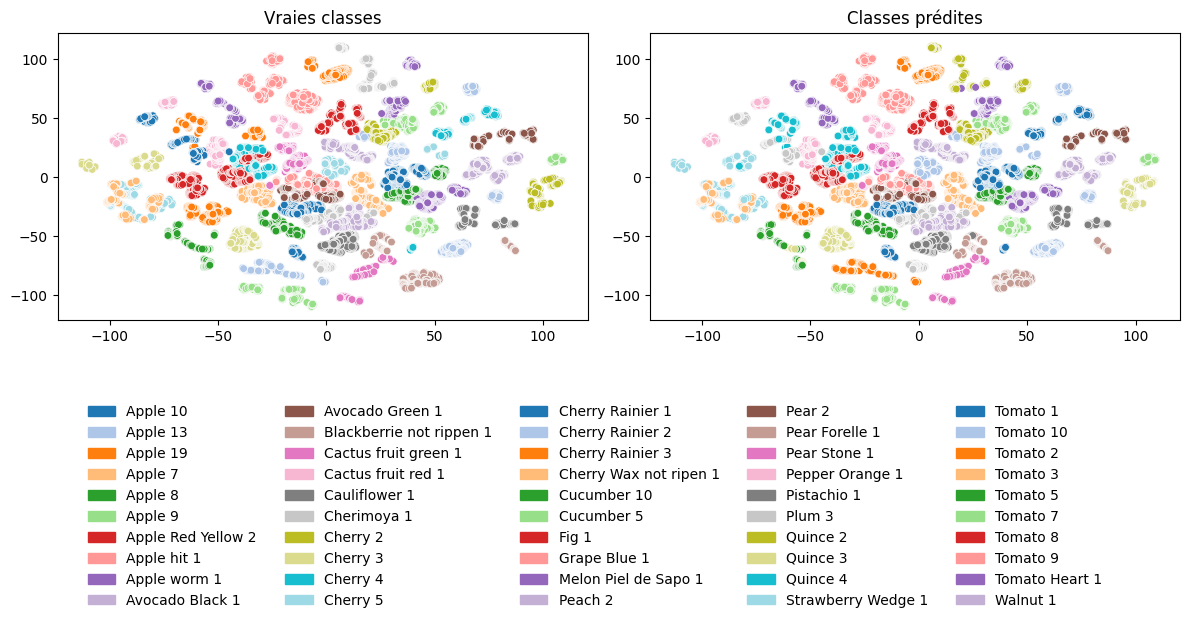

In [14]:
# Réduction t-SNE
reducer = TSNE(n_components=2, random_state=42, perplexity=30)
X_2d = reducer.fit_transform(X_test)

# Visualisation avec légende unique
plt.figure(figsize=(12, 5))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y_test_labels, palette='tab20', s=30, legend=False, ax=ax1)
plt.title("Vraies classes")
xlim, ylim = plt.xlim(), plt.ylim()
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y_pred, palette='tab20', s=30, legend=False, ax=ax2)
plt.title("Classes prédites")
plt.xlim(xlim)
plt.ylim(ylim)

classes = sorted(set(y_test_labels) | set(y_pred))
palette = sns.color_palette('tab20', len(classes))
handles = [mpatches.Patch(color=palette[i], label=cls) for i, cls in enumerate(classes)]
plt.figlegend(handles=handles, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.25), frameon=False)
plt.tight_layout()
plt.subplots_adjust(bottom=0.35)
plt.show()

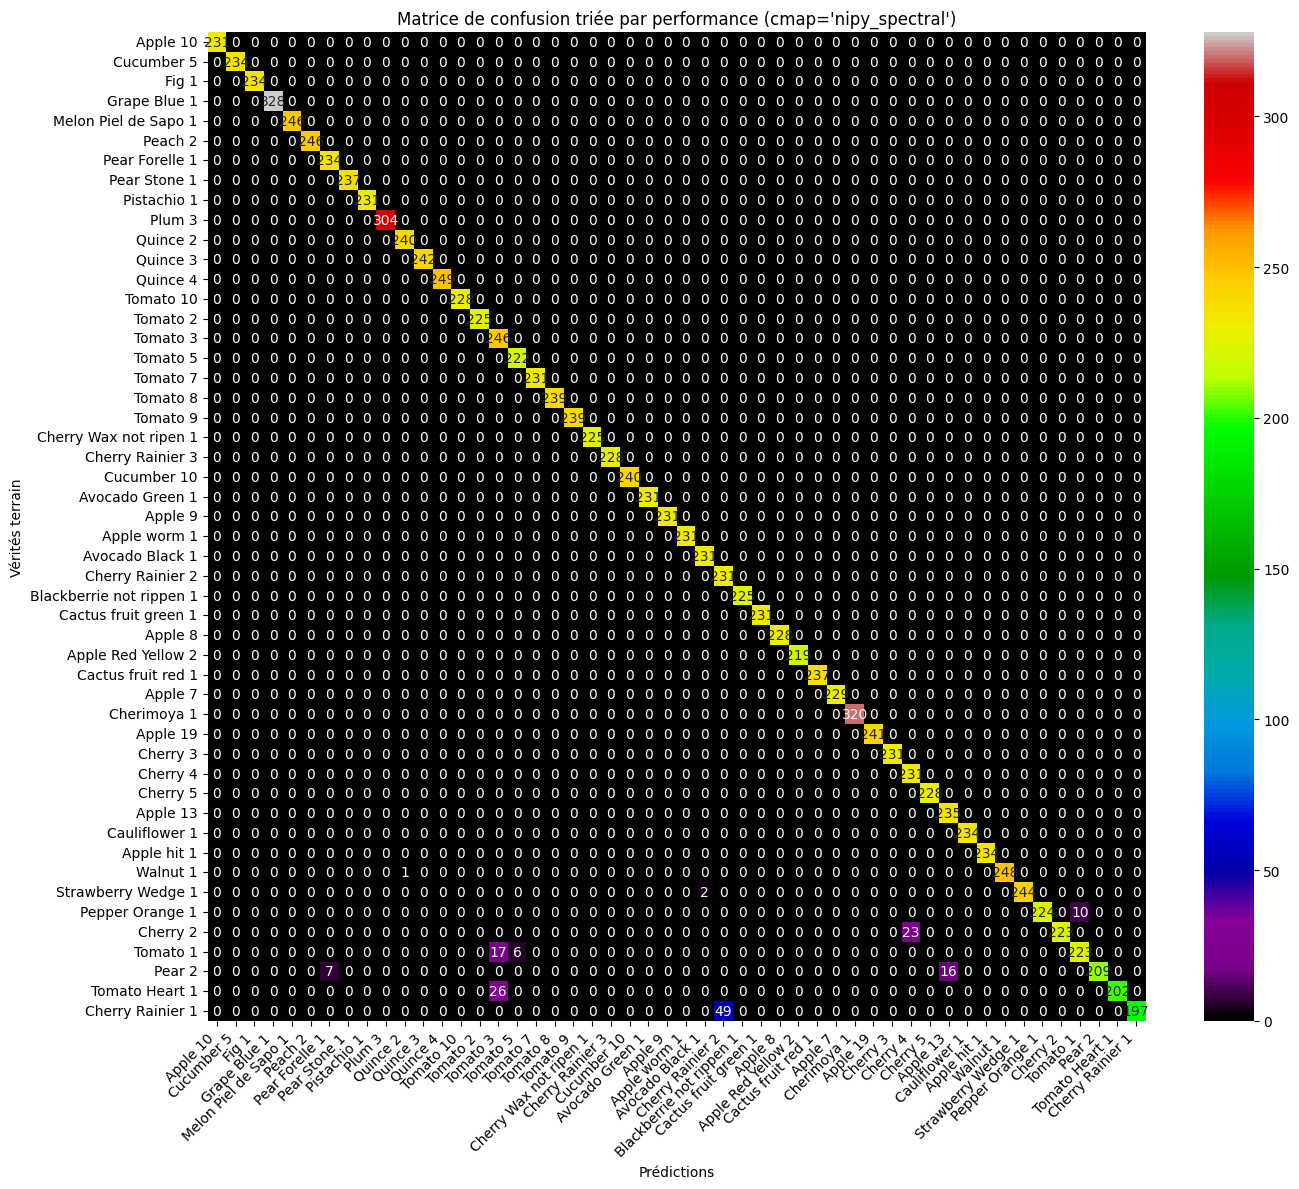

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 🔹 Classes uniques (labels texte)
classes = sorted(list(set(y_test_labels) | set(y_pred)))

# 🔹 Matrice de confusion brute
cm = confusion_matrix(y_test_labels, y_pred, labels=classes)

# 🔹 Normalisation ligne par ligne (rappel / recall)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# 🔹 Score de détection par classe = valeur diagonale (rappel)
diagonal_scores = np.diag(cm_norm)

# 🔹 Tri décroissant des classes selon score
sorted_indices = np.argsort(-diagonal_scores)
sorted_labels = [classes[i] for i in sorted_indices]
sorted_cm = cm[sorted_indices, :][:, sorted_indices]

# 🔸 Affichage heatmap avec cmap multicolore
plt.figure(figsize=(14, 12))
sns.heatmap(
    sorted_cm,
    annot=True,
    fmt='d',
    cmap='nipy_spectral',
    xticklabels=sorted_labels,
    yticklabels=sorted_labels
)
plt.xlabel("Prédictions")
plt.ylabel("Vérités terrain")
plt.title("Matrice de confusion triée par performance (cmap='nipy_spectral')")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
